# Cracking the Code 👩‍💻📈 Predicting Crypto Prices with Multiple TimeSeries and Covariates

Use time series forecasting models with covariates ('Days Until Bitcoin Halving', 'Fear & Greed Index') to predict crypto prices.

# Disclaimer

This article is solely intended for educational purposes and does not constitute financial advice. It focuses on the development and evaluation of time series forecasting models with covariates using a simplified real-world example. The results obtained from this model should not be used for automated trading activities.

# Intro

In this tutorial we will train and score multiple time series forecasting models (NBEATS, BayesianRidge, LGBMRegressor, XGBRegressor, LSTM) with covariates (Days Until Bitcoin Halving, Fear & Greed Index) for predicting crypto (BTC, ETH, DOT, MATIC, SOL) prices.

We will score & backtest the trained models, evaluate accuracy metrics per model and select the best performing model for the given task.

# Install & Import Requirements
Activate a Python environment and install the following

In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install darts
!pip install matplotlib
!pip install -U "gluonts[torch]==0.11.0" "optuna~=2.10.0"
!pip install ipykernel
!pip install --upgrade nbformat
!pip install lightgbm xgboost
!pip install seaborn
!pip install distributed
!pip install datasetsforecast
!pip install matplotlib
!pip install yfinance
# you might need to restart your ide or python notebook after installing the following
# for the changes to apply
!pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension

First, let's import a few things:

In [141]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


# Load crypto close price data from Yahoo Finance

Specify the list of cryptos for which you want to forecast prices

We will download close price data for:
* Bitcoin (BTC)
* Ethereum (ETH)
* Polkadot (DOT)
* Polygon (MATIC)
* Solana (SOL)

Feel free to extend the crypto_list with any other crypto coin.

In [142]:
crypto_list = ['BTC', 'ETH', 'DOT', 'MATIC', 'SOL']

Download from Yahoo Finance the close prices over time for the specified cryptos

In [143]:
from datetime import datetime

today_date = datetime.today().date()

data = pd.DataFrame()
for crypto in crypto_list: 
    all_price_data = yf.download(f'{crypto}-USD', interval = '1d', period='10y')
    if crypto == 'BTC':
        data.index = all_price_data.index
        # add missing dates in index
        idx_dates = list(pd.date_range(min(data.index), today_date))
        data = data.reindex(idx_dates, None)

    data[f'{crypto}'] = all_price_data['Close']

data.tail()

[*********************100%***********************]  1 of 1 completed


/var/folders/rn/j1t3lrd938bf8zng2m3h5nlh0000gn/T/ipykernel_19419/1762341223.py:12: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.
  data = data.reindex(idx_dates, None)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC,ETH,DOT,MATIC,SOL
Date,,,,,
2023-10-14,26861.707031,1555.256836,3.736276,0.517564,22.011719
2023-10-15,27159.652344,1558.069824,3.754978,0.515421,21.922028
2023-10-16,28519.466797,1600.534302,3.786211,0.534121,23.982958
2023-10-17,28415.748047,1565.439575,3.675057,0.519471,23.959318
2023-10-18,28510.232422,1575.007690,3.678230,0.518109,23.955900


Forward fill missing values

In [144]:
data = data.fillna(method="ffill")
data.tail()

,BTC,ETH,DOT,MATIC,SOL
Date,,,,,
2023-10-14,26861.707031,1555.256836,3.736276,0.517564,22.011719
2023-10-15,27159.652344,1558.069824,3.754978,0.515421,21.922028
2023-10-16,28519.466797,1600.534302,3.786211,0.534121,23.982958
2023-10-17,28415.748047,1565.439575,3.675057,0.519471,23.959318
2023-10-18,28510.232422,1575.007690,3.678230,0.518109,23.955900


Drop today's date for which we don't have yet the close price yet

In [145]:
data = data.loc[data.index!=str(today_date)]
data = data.fillna(0)

# Plot data

Plot crypto ('BTC', 'ETH', 'DOT', 'MATIC', 'SOL') close price data over time

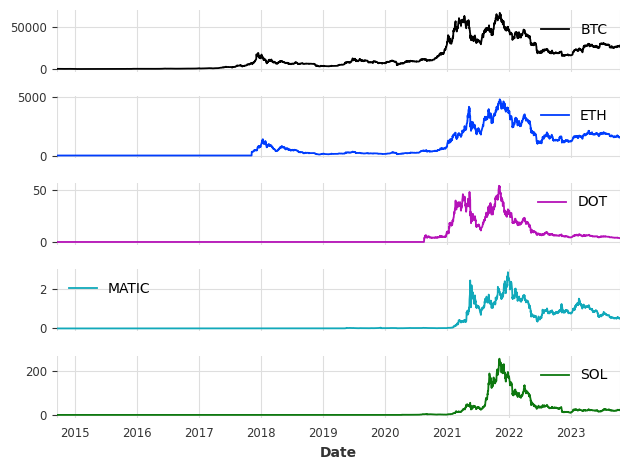

In [146]:
data.plot(subplots=True)

plt.tight_layout()
plt.show()

## Convert Dataframe to Darts TimeSeries

`TimeSeries` is the main class in darts. It represents a univariate or *multivariate* time series, deterministic or stochastic.

* `Univariate Series:` A time-ordered sequence of data with one variable, such as the price of one BTC over time.

* `Multivariate Series:` A time-ordered sequence of data with multiple variables observed simultaneously, such as the prices of multiple cryptos over time.

* `Deterministic Series:` A deterministic time series is a sequence of data where the future values can be precisely determined or predicted from the past values and known mathematical equations or rules. There is no randomness or uncertainty involved in the evolution of the time series; it follows a clear, predetermined pattern or formula.

* `Stochastic Series:` A stochastic time series is a sequence of data in which future values cannot be precisely determined based solely on past values and mathematical rules. Instead, randomness or uncertainty plays a significant role in the evolution of the time series. Stochastic time series models incorporate probabilistic elements to account for this uncertainty and are used in situations where inherent randomness or noise affects the data.

The data is organized within an array with a shape of (time, dimensions, samples), where dimensions refer to the different components or columns within the multivariate series, and samples represent the various data points within each series. 

Additionally, each series is associated with a `time_index` which can contain either `datetime` values (as a `pandas.DateTimeIndex`) or integer indices (as a `pandas.RangeIndex`).

In our specific scenario, we are dealing with a multivariate series where each column corresponds to a different cryptocurrency, the values represent crypto closing prices, and the indices consist of dates.

In [147]:
from darts import TimeSeries
data = data.reset_index()
series = TimeSeries.from_dataframe(data, time_col="Date", value_cols=crypto_list)

## Create Training & Validation Series

In the upcoming section, we'll partition our `TimeSeries` into two segments: a **training series** and a **validation series**. 

The *training series* will comprise **data up to 28 days prior**, while the validation series will include the remaining data. 

Our **objective** is to employ the training series for forecasting cryptocurrency prices within the validation series, assess model accuracy through metrics, and determine the best-performing model for the task at hand.

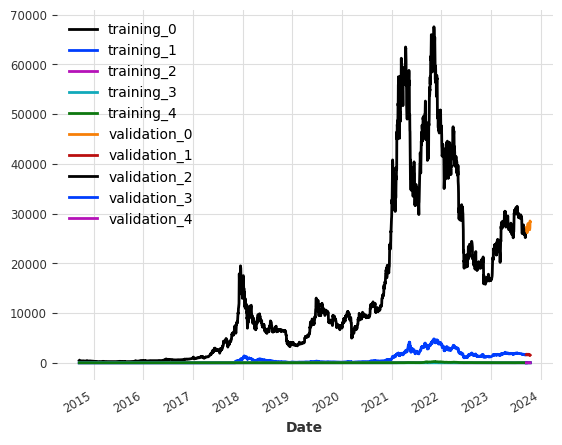

In [148]:
from datetime import datetime, timedelta

val_set_size = 28
val_set_split_date = max(data["Date"])-timedelta(days=val_set_size)
train, val = series.split_before(val_set_split_date)
train.plot(label='training')
val.plot(label='validation')

# Scale data

Scaling these series to a range of 0 to 1 will be advantageous for most machine learning models.

We will use a [Scaler](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.scaler.html) for this:

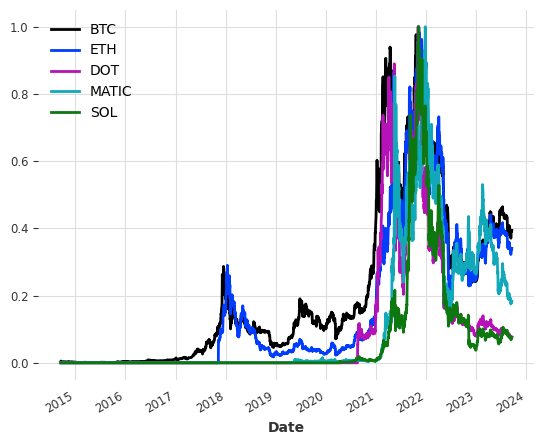

In [149]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
scaler = scaler.fit(train)
train_scaled = scaler.transform(train)
train_scaled = train_scaled.astype("float32")
val_scaled = scaler.transform(val)
val_scaled = val_scaled.astype("float32")
train_scaled.plot()

# Inspect Seasonality

It's apparent that the data exhibits a prolonged cyclic pattern, but let's employ the auto-correlation function (ACF) to explore whether there is any weekly or monthly seasonality in the BTC closing price.

# Autocorrelation Function (ACF)

The time series **autocorrelation function (ACF)** is a statistical tool that measures the correlation between a time series and its lagged versions. The ACF is a function of the lag, which is the number of time steps between the two versions of the time series.

The ACF can be used to identify the presence of autocorrelation in a time series. Autocorrelation is a phenomenon where the values of a time series are correlated with their own past values.

The ACF is calculated by correlating the time series with itself at different lags. The correlation coefficient is calculated for each lag, and the results are plotted as a function of the lag. The ACF typically decays as the lag increases, but it can also have spikes at certain lags.

The spikes in the ACF indicate the presence of autocorrelation at those lags. The height of the spike indicates the strength of the autocorrelation.

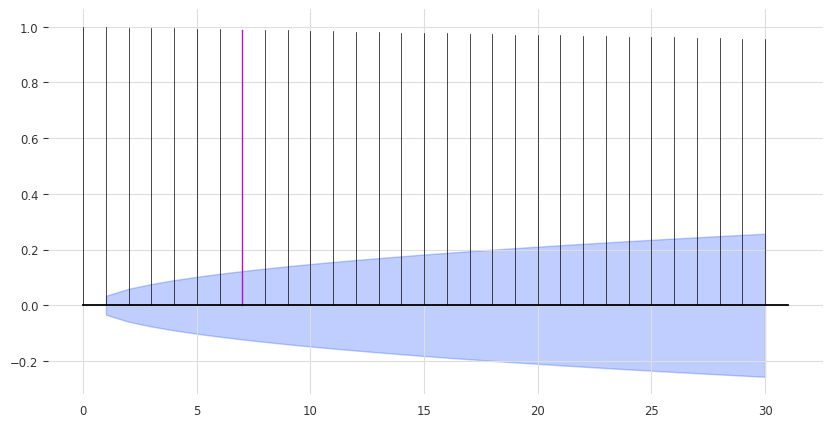

In [150]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_scaled["BTC"], m=7, alpha=0.05, max_lag=30)

This plot illustrates the AutoCorrelation Function (ACF) for the Bitcoin cryptocurrency's closing price time series. As the lag increases, the ACF exhibits a diminishing pattern. 

Notably, the ACF value at lag 1 is nearly equal to 1. This suggests the presence of autocorrelation at lag 1, signifying a correlation between the current BTC closing price and the BTC closing price from the previous day.

Furthermore, we do not detect any weekly recurring patterns from the 30 days plot.

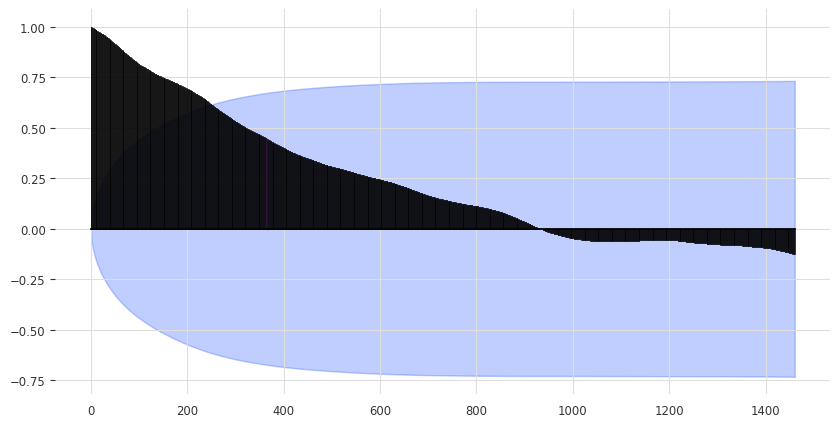

In [151]:
plot_acf(train_scaled["BTC"], m=365, alpha=0.05, max_lag=4*365)

We can discern a subtle 6-month seasonality and a more extended cyclic pattern that could be linked to the four-yearly Bitcoin halving events.

The shaded blue area defines the statistical significance level at a confidence of $\alpha=5%$. It's also possible to conduct a statistical assessment of seasonality for every potential period `m`:

In [152]:
for m in range(2, 8*365):
    is_seasonal, period = check_seasonality(train_scaled["BTC"], m=m, alpha=0.05, max_lag=8*365)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

The BTC close price does not seem to have any seasonal pattern with significance of the statistics for a confidence level of $\alpha = 5\%$

## Covariates: Leveraging External Data 

In addition to the target series (the series we aim to forecast), many models in Darts also accept covariate series as input. 

**Covariates** are series that we don't intend to predict but can offer valuable supplementary information to the models. Both targets and covariates can be either multivariate or univariate.

There are two types of covariate time series in Darts:

* `past_covariates` consist of series that may not be known in advance of the forecast time. These can, for example, represent variables that need to be measured and aren't known ahead of time. Models don't use future values of past_covariates when making predictions.
* `future_covariates` include series that are known in advance, up to the forecast horizon. These can encompass information like calendar data, holidays, weather forecasts, and more. Models capable of handling future_covariates consider future values (up to the forecast horizon) when making predictions.

![covariates](https://unit8co.github.io/darts/_images/covariates-highlevel.png)

Each covariate can potentially be multivariate. If you have multiple covariate series (e.g., month and year values), you should use `stack()` or `concatenate()` to combine them into a multivariate series.

The covariates you provide can be longer than necessary. Darts will adjust and align them to forecast the target based on the time indexes of the different series. However, an error will be raised if your covariates don't span a sufficient time range.

In the following cells, we use the `darts.utils.timeseries_generation.datetime_attribute_timeseries()` function to generate series containing month and year values. We then `concatenate()` these series along the "component" axis to create a covariate series with two components (month and year) for each target series. For simplicity, we directly scale the month and year values to a range of approximately 0 to 1.

# Future & Past Covariates

We will use: 

* The Fear & Greed index as `past_covariates`
* The Days Until Halving as `future_covariates`

# Get Fear & Greed Index Data ([Source](https://www.cointree.com/learn/crypto-fear-and-greed-index/))

The **Crypto Fear and Greed Index** analyzes the cryptocurrency market's overall sentiment, drawing insights from social signals and market trends in Bitcoin, Ethereum, and other prominent cryptocurrencies. It's termed an 'index' as it consolidates diverse data sources into a unified metric.

The index is divided into the following four categories:

* **0–24: Extreme fear (orange)**
* **25–49: Fear (amber/yellow)**
* **50–74: Greed (light green)**
* **75–100: Extreme greed (green)**

In [153]:
import requests
import itertools
fear_greed_data_url = "https://api.alternative.me/fng/?limit=0&format=json&date_format=cn"  
# sending get request and saving the response as response object
fear_greed_data_request = requests.get(url = fear_greed_data_url)
fear_greed_data = fear_greed_data_request.json()
# create a dataframe with the fear and greed index value per day
fear_greed_data_df = pd.DataFrame(fear_greed_data["data"])
# convert timestamp to datetime
fear_greed_data_df["timestamp"] = pd.to_datetime(fear_greed_data_df["timestamp"])
# set timestamp as the dataframe row index
fear_greed_data_df = fear_greed_data_df.set_index("timestamp")
# add missing date indices
idx_dates = list(pd.date_range(min(fear_greed_data_df.index), max(fear_greed_data_df.index)))
fear_greed_data_df = fear_greed_data_df.reindex(idx_dates, None)
# forward fill missing values
fear_greed_data_df["value"] = fear_greed_data_df["value"].fillna(method="ffill")
# drop todays date for which we don't have the final fear and greed index value
fear_greed_data_df = fear_greed_data_df.loc[fear_greed_data_df.index!=str(today_date)]
fear_greed_data_df.tail()

/var/folders/rn/j1t3lrd938bf8zng2m3h5nlh0000gn/T/ipykernel_19419/3840698127.py:15: FutureWarning: Interpreting call
	'.reindex(a, b)' as 
	'.reindex(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise a 'TypeError'.
  fear_greed_data_df = fear_greed_data_df.reindex(idx_dates, None)


,value,value_classification,time_until_update
timestamp,,,
2023-10-13,44,Fear,NaN
2023-10-14,47,Neutral,NaN
2023-10-15,45,Fear,NaN
2023-10-16,47,Neutral,NaN
2023-10-17,52,Neutral,NaN


Create a Darts timeseries from the Fear & Greed Index dataframe values

In [154]:
fear_and_greed_series = TimeSeries.from_times_and_values(fear_greed_data_df.index, fear_greed_data_df["value"])

# Get Days Until Next Bitcoin Halving

![alternatvie text](https://content-hub-static.crypto.com/static/6851d4d3e7092bad0d573d72576f2660/c9af3/Research_Bitcoin-Halving_effect_on_price_infographic.jpg)

## What Is Bitcoin Halving? ([source](https://www.forbes.com/advisor/au/investing/cryptocurrency/bitcoin-halving/#:~:text=Bitcoin%20halving%20is%20when%20the,counteract%20inflation%20by%20maintaining%20scarcity.))

**Bitcoin halving** refers to the reduction of rewards for bitcoin mining, which occurs every four years. This policy is embedded in Bitcoin's mining algorithm to combat inflation by preserving its scarcity.

## Frequency of Halving Events

Approximately every four years, or after every 210,000 blocks have been mined, the number of newly issued bitcoins is halved. The timing depends on the average block mining rate, which is approximately 10 minutes per block.

## Impact of Halving on Bitcoin's (and the Broader Crypto) Price? ([source](https://crypto.com/university/what-is-bitcoin-halving))

The halving can influence BTC price in several ways:

* **Halving reduces rewards**, fostering a sustainable network growth. By slowing the generation of new bitcoins, it ensures the limited and finite supply of Bitcoin, which can contribute to its long-term value.

* **The inflation rate of Bitcoin decreases after a halving**, resulting in a reduced supply of new coins entering the market.

This subject sparks ongoing debate among market analysts and participants. Some believe the halving will trigger a substantial Bitcoin price increase due to reduced inflation, potentially driving higher demand and increased value. Others argue that the halving event is already factored into the market price and will have no impact on the cryptocurrency's value.

In [155]:
halvings_dict = {1:"2012-11-28", 2:"2016-09-09", 3:"2020-05-11", 4:"2024-04-27"}
halving_cols=[]
# create a column with the date difference in days between the row Date and the next halving dates 
for key in halvings_dict:
    # add a column for each one of the halving dates, with the date of the halving as values
    data[f'halving_{key}_date'] = pd.to_datetime(halvings_dict[key]).date() 
    # calculate the difference in days between the row Date and each one of the halving dates
    diff = (pd.to_datetime(data.Date) - pd.to_datetime(data[f'halving_{key}_date'])).dt.days 
    # for each halding date, create a column the date difference value
    data[f'days_since_halving_{key}'] = diff
    # remove negative date differences because they refer to halving dates before the index dates
    data[f'days_since_halving_{key}'] = np.where(data[f'days_since_halving_{key}']<0, None, data[f'days_since_halving_{key}'])
    data = data.drop(columns=[f'halving_{key}_date'])
    # create a list with the columns names holding the number of days between the index date and each halving
    halving_cols.append(f'days_since_halving_{key}')

# keep the minimun value of all the positive halving date differences
# this difference refers to the first halving date after the index Date
data["days_since_last_halving"] = data[halving_cols].min(axis=1)
data = data.drop(columns=halving_cols)
data.head()

,Date,BTC,ETH,DOT,MATIC,SOL,days_since_last_halving
0,2014-09-17,457.334015,0.0,0.0,0.0,0.0,658.0
1,2014-09-18,424.440002,0.0,0.0,0.0,0.0,659.0
2,2014-09-19,394.795990,0.0,0.0,0.0,0.0,660.0
3,2014-09-20,408.903992,0.0,0.0,0.0,0.0,661.0
4,2014-09-21,398.821014,0.0,0.0,0.0,0.0,662.0


In [156]:
from darts import TimeSeries
data = data.set_index("Date")
days_until_halving_series = TimeSeries.from_times_and_values(data.index, data["days_since_last_halving"])

In [157]:
print(f"We have Fear & Greed index values since {min(fear_greed_data_df.index.date)}")

We have Fear & Greed index values since 2018-02-01


Drop crypto price data for dates before the minimum Fear & Greed index value date

In [158]:
_, series = series.split_before(min(fear_greed_data_df.index))
_, train = train.split_before(min(fear_greed_data_df.index))
_, train_scaled = train_scaled.split_before(min(fear_greed_data_df.index))
_, days_until_halving_series = days_until_halving_series.split_before(min(fear_greed_data_df.index))

# Define past covariates

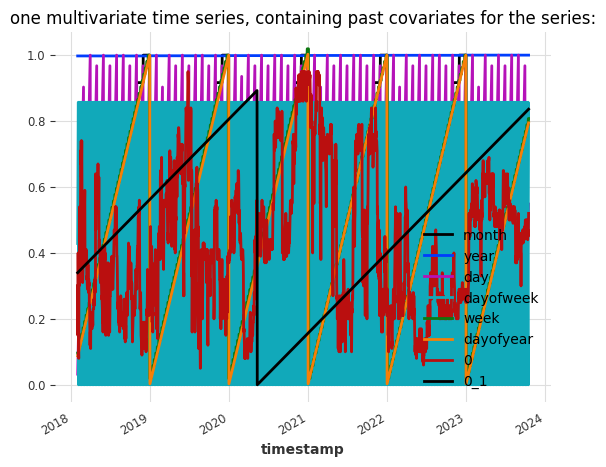

In [159]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

past_covs = concatenate(
    [
        dt_attr(fear_and_greed_series.time_index, "month", dtype=np.float32) / 12,
        dt_attr(fear_and_greed_series.time_index, "year", dtype=np.float32) / max(train.time_index.year),
        dt_attr(fear_and_greed_series.time_index, "day", dtype=np.float32) / 31,
        dt_attr(fear_and_greed_series.time_index, "dayofweek", dtype=np.float32) / 7,
        dt_attr(fear_and_greed_series.time_index, "week", dtype=np.float32) / 52,
        dt_attr(fear_and_greed_series.time_index, "dayofyear", dtype=np.float32) / 365,
        fear_and_greed_series / 100,
        days_until_halving_series / 1500,
    ],
    axis="component",
)

past_covs.plot()
plt.title(
    "one multivariate time series, containing past covariates for the series:"
);

# Define future covariates

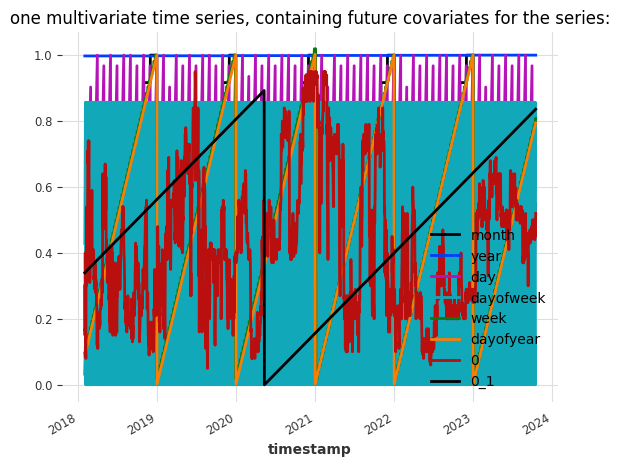

In [160]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

future_covs = concatenate(
    [
        dt_attr(fear_and_greed_series.time_index, "month", dtype=np.float32) / 12,
        dt_attr(fear_and_greed_series.time_index, "year", dtype=np.float32) / max(train.time_index.year),
        dt_attr(fear_and_greed_series.time_index, "day", dtype=np.float32) / 31,
        dt_attr(fear_and_greed_series.time_index, "dayofweek", dtype=np.float32) / 7,
        dt_attr(fear_and_greed_series.time_index, "week", dtype=np.float32) / 52,
        dt_attr(fear_and_greed_series.time_index, "dayofyear", dtype=np.float32) / 365,
        days_until_halving_series / 1500
    ],
    axis="component",
)


past_covs.plot()
plt.title(
    "one multivariate time series, containing future covariates for the series:"
);

# Machine learning and global models
Darts supports many machine learning and deep learning forecasting models such as:

* [RegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) can wrap around any sklearn-compatible regression model to produce forecasts.
* [RNNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html) is a flexible RNN implementation, which can be used like DeepAR.
* [NBEATSModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html) implements the N-BEATS model.
* [TFTModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html) implements the Temporal Fusion Transformer model.
* [TCNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) implements temporal convolutional networks.
* ...

In addition to adhering to the same fundamental `fit()`/`predict()` interface as other models, these models are considered  global models due to their ability to be trained on multiple time series, a concept sometimes referred to as meta-learning.

This feature holds particular significance when using machine learning-based models for forecasting. More often than not, ML models, especially deep learning models, require substantial amounts of data for training, often comprising numerous distinct yet interconnected time series. 

In Darts, a straightforward method for specifying multiple `TimeSeries` involves utilizing a `Sequence` of `TimeSeries`, which can be as simple as a list of `TimeSeries`.

# Regression Forecasting Models

[RegressionModel's](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html) serves as a forecasting model that encapsulates sklearn-compatible regression models. The internal regression model is employed to project future values of the target series, taking into account specific lags of the target as well as past and future covariates. Behind the scenes, time series data is organized into a tabular format to create a suitable training dataset.

By default, the `RegressionModel` utilizes linear regression. However, it's effortless to employ any desired sklearn-compatible regression model by specifying the `model` parameter. For convenience, Darts also offers a set of pre-built models:

* [RandomForest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.random_forest.html) wraps around `sklearn.ensemble.RandomForestRegressor`.
* [LightGBMModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.gradient_boosted_model.html) wraps around `lightbm`.
* [LinearRegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html) wraps around `sklearn.linear_model.LinearRegression` (accepting the same kwargs).

For instance, here's an example of fitting a Bayesian ridge regression model to a two-series problem:

# BayesianRidge

BayesianRidge is a regression model using Bayesian inference for parameter estimation, offering probabilistic predictions with uncertainty. It includes regularization to prevent overfitting, controlled by hyperparameters (lambda and alpha) that can be selected through methods like cross-validation. This model's forecasting is akin to weather prediction, providing sophisticated, probabilistic forecasts by considering various factors and representing uncertainty as a probability distribution.

Much like transformers like `Scaler`, the computation of metrics can be parallelized across `N` processors when handling numerous series pairs by setting `n_jobs=N`.

In [161]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

lags = 3*30
RidgeRegressionModel_model = RegressionModel(lags=lags, lags_future_covariates=[-6, 0], model=BayesianRidge())

RidgeRegressionModel_model.fit(
    train_scaled, future_covariates=future_covs.astype("float32")
)

RegressionModel(lags=90, lags_past_covariates=None, lags_future_covariates=[-6, 0], output_chunk_length=1, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True)

* `lags` is telling the `RegressionModel` to look at the past n lags of the target.
* In addition, `lags_future_covariates=[-6, 0]` means that the model will also look at lags of the `future_covariates` we provide. Here we enumerate the precise lags we want the models to take into account; the "-6th" and the "0th" lags. The "0th" lag means the "current" lag (i.e., at the time step being forecasted); obviously, knowning this lag requires knowing the data in advance (hence the fact we are using `future_covariates`). Similarly, `-6` means we also look at the value of the covariates 6 months before the forecasted time step (which also requires to know the covariates in advance if we are forecasting at a horizon more than 6 steps ahead).
* `model=BayesianRidge()` provides the actual inner regression model.

* `lags`: instructs the RegressionModel to consider the previous 'n' lags of the target series.
* `lags_future_covariates=[-6, 0]`, the model is configured to also incorporate lags from the provided future_covariates. This includes specific lags we want the model to account for, such as the "-6th" and "0th" lags. The "0th" lag pertains to the current time step, which requires advanced knowledge of the data (hence the use of future_covariates). Similarly, the "-6" lag signifies the consideration of covariate values from 6 months prior to the forecasted time step, which also necessitates foreknowledge of the covariates if we are forecasting beyond a 6-step horizon.
* `model=BayesianRidge()` specifies the actual inner regression model to be used.

Now, let's proceed to generate some forecasts:

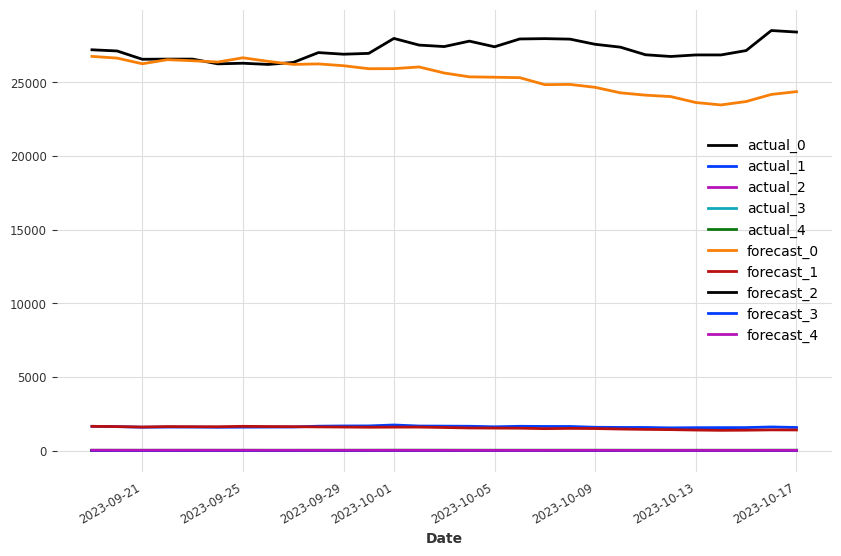

In [162]:
RidgeRegressionModel_pred_scaled = RidgeRegressionModel_model.predict(
    series=train_scaled,
    future_covariates=future_covs.astype("float32"),
    n=len(val),
)

# scale back:
RidgeRegressionModel_pred = scaler.inverse_transform(RidgeRegressionModel_pred_scaled)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
RidgeRegressionModel_pred.plot(label="forecast")

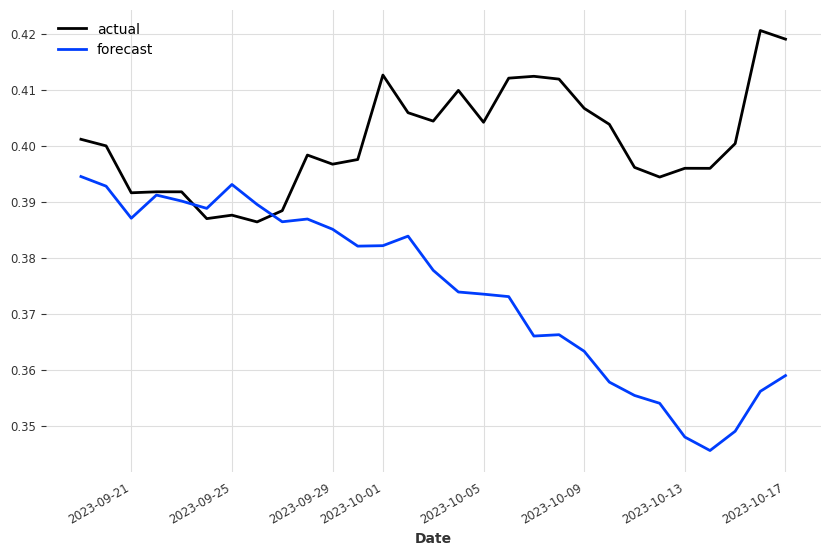

In [163]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
RidgeRegressionModel_pred_scaled["BTC"].plot(label="forecast")

At first glance, the forecast doesn't seem great. Both the map and forecasted prices are quite off.
But if we look closely at the first week of the forecast, it seems like this model might have a knack for telling us if the price will go up or down tomorrow. To really check how well it does, we need to run some backtesting to see if it's better than just guessing randomly.

# Time Series Backvalidation

The `historical_forecasts` feature in Darts assesses how a time series model would have performed in the past by generating and comparing predictions to actual data. Here's how it works:

* **Model Training:** Train your time series forecasting model using historical data.
* **Historical Forecasts:** Use the function to create step-by-step forecasts for a historical period preceding the training data.
* **Comparison:** Compare historical forecasts to actual values from that period.
* **Performance Evaluation:** Apply metrics like MSE, RMSE, or MAE for quantitative assessment.
* **Insights and Refinement:** Analyze the results to gain insights and improve the model.

This process is essential for validating a model's historical performance, testing different strategies, and building confidence in its accuracy before real-time use.

  0%|          | 0/406 [00:00<?, ?it/s]

MAPE = 24.80


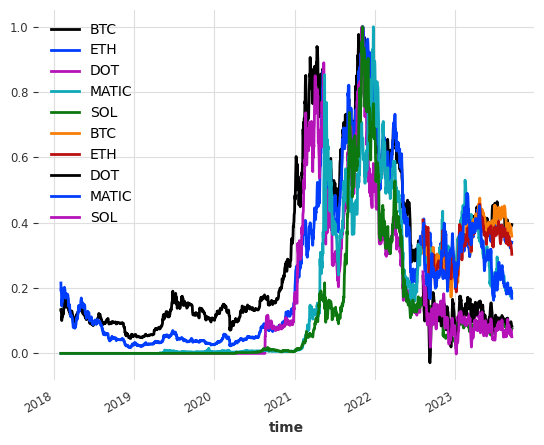

In [164]:
from darts.metrics import mape

bayes_ridge_model_backval = RegressionModel(
    lags=lags, lags_future_covariates=[0], model=BayesianRidge()
)

backval = bayes_ridge_model_backval.historical_forecasts(
    train_scaled, 
    future_covariates=future_covs.astype("float32"), 
    start=0.8, 
    forecast_horizon=7, 
    verbose=True,
    retrain=True
)

print("MAPE = %.2f" % (mape(backval, train_scaled )))
train_scaled.plot()
backval.plot()

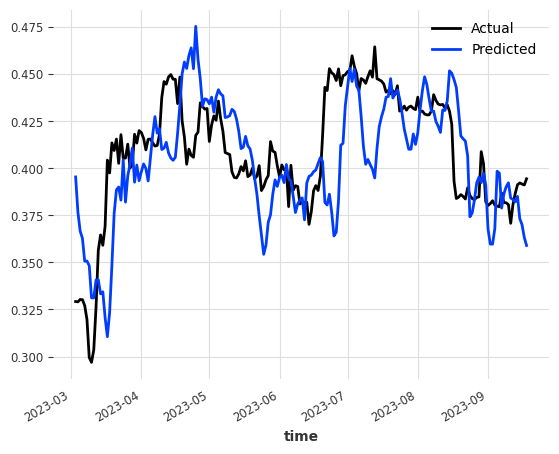

In [165]:
train_scaled["BTC"][-200:].plot(label="Actual")
backval["BTC"][-200:].plot(label="Predicted")

## Using deep learning: example with N-BEATS

Next, we will train an [N-BEATS model](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html) which offers numerous hyperparameters for tuning, including the number of stacks and layers. However, in this case, we'll keep it simple and use the default hyperparameters. The two critical hyperparameters we need to specify are:
* `input_chunk_length`: This represents the model's * `lookback window and determines how many historical time steps the neural network considers to generate its forward pass output.
* `output_chunk_length`: This defines the forward window or how many future time steps the neural network predicts in a forward pass.

The inclusion of the `random_state` parameter ensures result reproducibility. We'll use multiples of the seasonality as our values. With these settings in place, we're prepared to fit our model to our two series by passing a list containing both series to the `fit()` function.

# N-BEATS

N-BEATS is a deep learning model for time series forecasting. It employs neural basis expansion to represent time series data as a linear combination of learned basis functions.

N-BEATS consists of stacks, each with interconnected blocks in a residual fashion, enabling it to capture long-range dependencies in time series data.

The model automatically learns basis functions during training, updating them via backpropagation for better data representation.

N-BEATS is highly effective, surpassing various forecasting models, including statistical and deep learning models.

In essence, it learns basis functions from historical data to forecast future stock prices, accounting for multiple influencing factors like economic conditions and investor sentiment

In [166]:
from darts.models import NBEATSModel

input_chunk_length = 6*30
output_chunk_length = len(val)

Not all models support all types of covariates. `NBEATSModel` supports only `past_covariates`. Therefore, even though our covariates represent calendar information and are known in advance, we will use them as `past_covariates` with N-BEATS. To train, all we have to do is give them as `past_covariates` to the `fit()` function, in the same order as the targets:

In [167]:
from darts.dataprocessing.transformers import Scaler

NBEATSModel_model = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, random_state=42)
train_scaled = train_scaled.astype("float32")
val_scaled = val_scaled.astype("float32")
input_chunk_length
NBEATSModel_model.fit(
    train_scaled,
    past_covariates=past_covs.astype("float32"),
    epochs=5,
    verbose=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/evagian/.pyenv/versions/3.9.16/envs/timeseries_forecasting_with_covariates/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 24.5 M
---------------------------------------------------
24.5 M    Trainable params
15.3 K    Non-trainable params
24.5 M    Total params
97.865    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=180, output_chunk_length=29, random_state=42)

To generate forecasts, we need to supply our covariates as `past_covariates` once more when using the `predict()` function. It's important to note that even though the covariates contain data extending into the forecast horizon, the model won't use those future values. This is because it treats them as past covariates, not future ones.

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


env: PYTORCH_ENABLE_MPS_FALLBACK=1


/Users/evagian/.pyenv/versions/3.9.16/envs/timeseries_forecasting_with_covariates/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

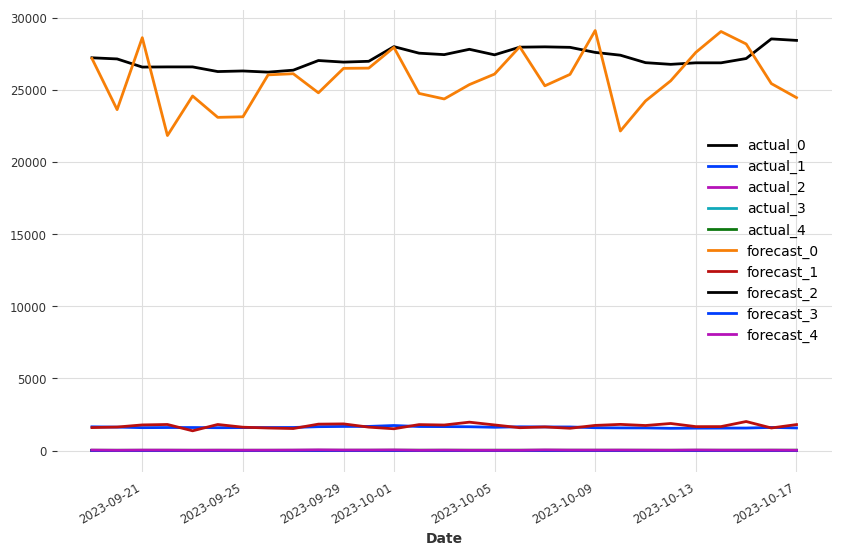

In [173]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

NBEATSModel_model_pred_scaled = NBEATSModel_model.predict(series=train_scaled, past_covariates=past_covs.astype("float32"), n=len(val))

# scale back:
NBEATSModel_model_pred = scaler.inverse_transform(NBEATSModel_model_pred_scaled)
plt.figure(figsize=(10, 6))
val.plot(label="actual")
NBEATSModel_model_pred.plot(label="forecast")

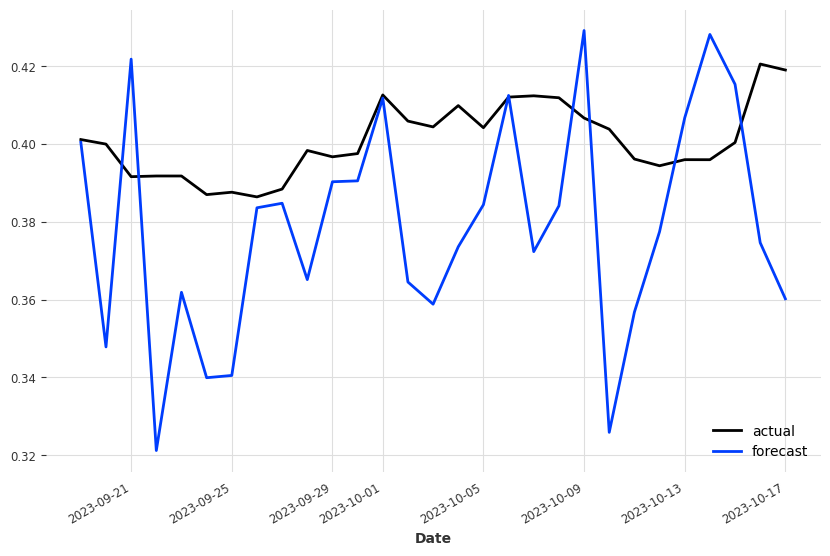

In [174]:
plt.figure(figsize=(10, 6))
val_scaled["BTC"].plot(label="actual")
NBEATSModel_model_pred_scaled["BTC"].plot(label="forecast")

# Create evaluation metrics dictionary

This dictionary will hold the name of the model and the model accuracy metrics.

At the end we will use it to select the best performing model.

In [175]:
from darts.metrics import mape, mse, smape

accuracy_metrics_dict = { }

accuracy_metrics_dict["BayesianRidge"] = { }
accuracy_metrics_dict["BayesianRidge"]["mse"] = mse(RidgeRegressionModel_pred, val)
accuracy_metrics_dict["BayesianRidge"]["mape"] = mape(RidgeRegressionModel_pred, val)
accuracy_metrics_dict["BayesianRidge"]["smape"] = smape(RidgeRegressionModel_pred, val)

accuracy_metrics_dict["NBEATS"] = { }
accuracy_metrics_dict["NBEATS"]["mse"] = mse(NBEATSModel_model_pred, val)
accuracy_metrics_dict["NBEATS"]["mape"] = mape(NBEATSModel_model_pred, val)
accuracy_metrics_dict["NBEATS"]["smape"] = smape(NBEATSModel_model_pred, val)

accuracy_metrics_dict

{'BayesianRidge': {'mse': 1045231.8154912309,
  'mape': 23.21954875101173,
  'smape': 17.727323342563793},
 'NBEATS': {'mse': 1209577.181821385,
  'mape': 23.683633166633754,
  'smape': 28.431571052365836}}

It seems that the BayesianRidge model performs better

# BayesianRidge is better

In [176]:
accuracy_metrics_df = pd.DataFrame.from_dict(accuracy_metrics_dict, orient='index').T
accuracy_metrics_df


,BayesianRidge,NBEATS
mse,1.045232e+06,1.209577e+06
mape,2.321955e+01,2.368363e+01
smape,1.772732e+01,2.843157e+01


In [177]:
accuracy_metrics_df = accuracy_metrics_df.reset_index()
accuracy_metrics_df

,index,BayesianRidge,NBEATS
0,mse,1.045232e+06,1.209577e+06
1,mape,2.321955e+01,2.368363e+01
2,smape,1.772732e+01,2.843157e+01


In [178]:

accuracy_metrics_df['best_model'] = accuracy_metrics_df.idxmin(axis=1, numeric_only=True)
accuracy_metrics_df = accuracy_metrics_df.rename(columns={"index": "metric"})
accuracy_metrics_df

,metric,BayesianRidge,NBEATS,best_model
0,mse,1.045232e+06,1.209577e+06,BayesianRidge
1,mape,2.321955e+01,2.368363e+01,BayesianRidge
2,smape,1.772732e+01,2.843157e+01,BayesianRidge


<Axes: xlabel='n', ylabel='best_model'>

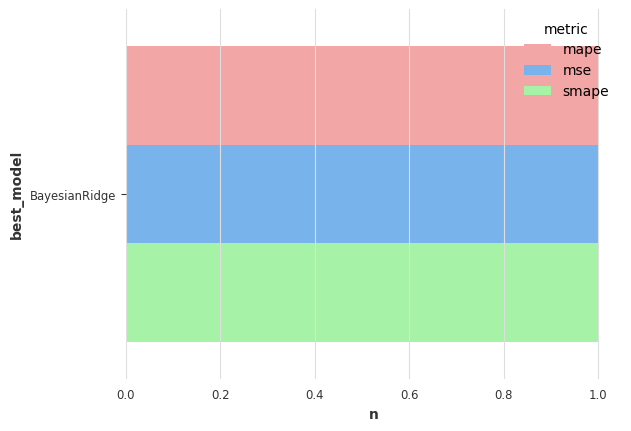

In [179]:
import seaborn as sns
# Choose the best model for each time series, metric, and cross validation window
accuracy_metrics_df['best_model'] = accuracy_metrics_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = accuracy_metrics_df.groupby(['metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sns.barplot(count_best_model, x='n', y='best_model', hue='metric', palette=colors)

# Disclaimer

This article is solely intended for educational purposes and does not constitute financial advice. It focuses on the development and evaluation of time series forecasting models with covariates using a simplified real-world example. The results obtained from this model should not be used for automated trading activities.

# Sources

* https://unit8co.github.io/darts/quickstart/00-quickstart.html